In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


## Read the data

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
ids = test['id']
test = test.drop(columns=['id'], axis=1)

## Categorize features

In [31]:
def categorize_features(df):
    # For 'FCVC'
    for i, x in enumerate(df['FCVC']):
        if 0 <= x <= 1.5:
            df.at[i, 'FCVC'] = 1
        elif 1.5 < x <= 2.5:
            df.at[i, 'FCVC'] = 2
        else:
            df.at[i, 'FCVC'] = 3

    # For 'NCP'
    for i, x in enumerate(df['NCP']):
        if 0 <= x <= 2:
            df.at[i, 'NCP'] = 1
        elif 2 < x <= 3.5:
            df.at[i, 'NCP'] = 2
        else:
            df.at[i, 'NCP'] = 3

    # For 'CH2O'
    for i, x in enumerate(df['CH2O']):
        if 0 <= x <= 1.5:
            df.at[i, 'CH2O'] = 1
        elif 1.5 < x <= 2.3:
            df.at[i, 'CH2O'] = 3
        elif 2.3 < x <= 2.7:
            df.at[i, 'CH2O'] = 2.6
        elif x > 2.7:
            df.at[i, 'CH2O'] = 3

    # For 'FAF'
    for i, x in enumerate(df['FAF']):
        if 0 <= x <= 0.5:
            df.at[i, 'FAF'] = 0
        elif 0.5 < x <= 1.5:
            df.at[i, 'FAF'] = 1
        elif 1.5 < x <= 2.2:
            df.at[i, 'FAF'] = 2
        elif x > 2.2:
            df.at[i, 'FAF'] = 3

    # For 'TUE'
    for i, x in enumerate(df['TUE']):
        if 0 <= x <= 0.5:
            df.at[i, 'TUE'] = 0
        elif 0.5 < x <= 1.5:
            df.at[i, 'TUE'] = 1
        else:
            df.at[i, 'TUE'] = 2

    return df

# Apply the function to train and test DataFrames
train = categorize_features(train)
test = categorize_features(test)

## Generate new features

In [32]:
def feature_generator(df):
    
    # Create a BMI column
    df['BMI'] = df['Weight'] / (df['Height']**2)
    
    # Create polynomial features
    df['Poly_Weight'] =  df['Weight']**2
    df['Poly_Height'] = df['Height']**2
    df['Poly_Age'] = df['Age']**2
    
    # Create interaction features
    df['Weight_Age'] = df['Weight'] * df['Age']
    df['Height_Age'] = df['Weight'] * df['Height']
    df['BMI_Age'] = df['Weight'] * df['BMI']
    df['All_cat'] = df['Weight'] * df['BMI'] * df['Height'] * df['Age']
    
    return df

# Apply feature generation to both train and test datasets
train = feature_generator(train)
test = feature_generator(test)

## Label encode categorical features

In [33]:
def label_encode_features(df):
    # Convert 'yes' and 'no' strings to integers
    df['family_history_with_overweight'] = df['family_history_with_overweight'].map({'yes': 1, 'no': 0})
    df['FAVC'] = df['FAVC'].map({'yes': 1, 'no': 0})
    df['SMOKE'] = df['SMOKE'].map({'yes': 1, 'no': 0})
    df['SCC'] = df['SCC'].map({'yes': 1, 'no': 0})
    
    # Encode CAEC column
    df['CAEC'] = df['CAEC'].map({'Sometimes': 0, 'Frequently': 1}).fillna(2).astype(int)
    
    # Encode CALC column
    df['CALC'] = df['CALC'].map({'Sometimes': 0, 'no': 1}).fillna(2).astype(int)
    
    # Encode MTRANS column
    df['MTRANS'] = df['MTRANS'].map({'Public_Transportation': 0, 'Automobile': 1}).fillna(2).astype(int)
    
    # Encode Gender column
    df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
    
    return df

# Apply the function to train and test DataFrames
train = label_encode_features(train)
test = label_encode_features(test)   

## One hot encode the categorical features

In [34]:
from sklearn.preprocessing import OneHotEncoder

# Define categorical features
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'MTRANS', 'TUE', 'FAF', 'CH2O', 'NCP', 'FCVC']

# Initialize OneHotEncoder
hot_encoder = OneHotEncoder()

# Fit and transform on training data
train_encoded = hot_encoder.fit_transform(train[categorical_features])

# Transform test data
test_encoded = hot_encoder.transform(test[categorical_features])


## Specify X and y

In [35]:
X = train.drop(columns=['NObeyesdad', 'id'], axis=1)
y = train['NObeyesdad']

## Train Test split and label encode the target

In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.3)

# Initialize LabelEncoder for target variable
label_encoder = LabelEncoder()

# Fit and transform encoder on training target variable
y_train = label_encoder.fit_transform(y_train)

# Transform test target variable using the same encoder
y_test = label_encoder.transform(y_test)

In [37]:
import optuna
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import accuracy_score
import joblib
import pickle
from optuna.samplers import TPESampler

## Optuna for catboost

In [38]:
# Define the objective function
def objective_cat(trial):
    # Define the search space for CatBoost hyperparameters
    cat_params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 1, 10),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.05, 1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100)
    }
    cat_model = CatBoostClassifier(**cat_params, silent=True)
    cat_model.fit(X_train, y_train)
    cat_predictions = cat_model.predict(X_test)
    cat_accuracy = accuracy_score(y_test, cat_predictions,)
    return cat_accuracy

study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=30)

# Define the best hyperparameters obtained from Optuna
best_params_cat = study_cat.best_params

# Instantiate CatBoostClassifier with the best hyperparameters
best_cat_model = CatBoostClassifier(**best_params_cat, silent=True)

# Fit the model on the training data
best_cat_model.fit(X_train, y_train)

# Obtain accuracy score
y_pred_cat = best_cat_model.predict(X_test)
accuracy_score(y_test, y_pred_cat)

# Save the trained model
joblib.dump(best_cat_model, 'best_cat_model.pkl')

[I 2024-02-04 23:20:57,648] A new study created in memory with name: no-name-79217472-40a0-4ef3-b5ff-b9cab4f9e298
/tmp/ipykernel_33/2555354767.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
[I 2024-02-04 23:20:59,612] Trial 0 finished with value: 0.731053307642903 and parameters: {'iterations': 254, 'learning_rate': 0.0037704857895808795, 'depth': 1, 'colsample_bylevel': 0.9198190593200093, 'min_data_in_leaf': 3}. Best is trial 0 with value: 0.731053307642903.
/tmp/ipykernel_33/2555354767.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rat

['best_cat_model.pkl']

## Optuna for lgbm

In [40]:
def objective_lgbm(trial):
    """
    Objective function to be minimized.
    """
    lgbm_param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": 3,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    lgbm = lgb.LGBMClassifier(**lgbm_param)
    lgbm.fit(X_train, y_train)
    preds_lgbm = lgbm.predict(X_test)
    accuracy = accuracy_score(y_test, preds_lgbm)
    return accuracy
sampler = TPESampler(seed=1)
study_lgbm = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=100)
print('Best parameters:', study_lgbm.best_params)
print('Best value:', study_lgbm.best_value)
model_lgbm = lgb.LGBMClassifier(**study_lgbm.best_params)
model_lgbm.fit(X_train, y_train)
y_pred_lgbm = model_lgbm.predict(X_test)
accuracy_score(y_test, y_pred_lgbm)
filename = "lightgbm.pkl"
pickle.dump(model_lgbm, open(filename, "wb"))

[I 2024-02-04 23:39:37,796] A new study created in memory with name: lightgbm
[I 2024-02-04 23:39:39,038] Trial 0 finished with value: 0.876204238921002 and parameters: {'lambda_l1': 5.6649755830282306e-05, 'lambda_l2': 0.030403280126677572, 'num_leaves': 2, 'feature_fraction': 0.5813995435791038, 'bagging_fraction': 0.48805353449026784, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 0 with value: 0.876204238921002.
[I 2024-02-04 23:39:44,695] Trial 1 finished with value: 0.9036608863198459 and parameters: {'lambda_l1': 1.2883876209377052e-05, 'lambda_l2': 3.72312200494449e-05, 'num_leaves': 139, 'feature_fraction': 0.6515167086419769, 'bagging_fraction': 0.8111317002380557, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 1 with value: 0.9036608863198459.
[I 2024-02-04 23:39:48,486] Trial 2 finished with value: 0.903339755940912 and parameters: {'lambda_l1': 1.763958399884789e-08, 'lambda_l2': 0.010819509974097813, 'num_leaves': 108, 'feature_fraction': 0.7352138

Best parameters: {'lambda_l1': 0.002077480169476262, 'lambda_l2': 1.0389659121829367, 'num_leaves': 13, 'feature_fraction': 0.47602227848522155, 'bagging_fraction': 0.9290735275447844, 'bagging_freq': 2, 'min_child_samples': 88}
Best value: 0.9081567116249197
[LightGBM] [Warning] feature_fraction is set=0.47602227848522155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47602227848522155
[LightGBM] [Warning] lambda_l2 is set=1.0389659121829367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0389659121829367
[LightGBM] [Warning] lambda_l1 is set=0.002077480169476262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002077480169476262
[LightGBM] [Warning] bagging_fraction is set=0.9290735275447844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9290735275447844
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.47602227848

## Optuna for xgb

In [41]:
def objective_xgb(trial):
    params = {
        "objective": "multi:softmax",
        "num_class": 7,
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "eval_metric": 'merror',
    }

    model_xgb = xgb.XGBClassifier(**params)
    model_xgb.fit(X_train, y_train, verbose=False)
    predictions_xgb = model_xgb.predict(X_test)
    accuracy_xgb = accuracy_score(y_test, predictions_xgb)
    return accuracy_xgb

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)
print('Best hyperparameters:', study_xgb.best_params)
print('Best accuracy:', study_xgb.best_value)

# Define the best hyperparameters obtained from Optuna
best_params_xgb = study_xgb.best_params

# Instantiate CatBoostClassifier with the best hyperparameters
best_xgb_model = xgb.XGBClassifier(**best_params_xgb, silent=True)

# Fit the model on the training data
best_xgb_model.fit(X_train, y_train)

# Obtain accuracy score
y_pred_xgb = best_xgb_model.predict(X_test)
accuracy_score(y_test, y_pred_xgb)

# Save the trained model
joblib.dump(best_xgb_model, 'best_xgb_model.pkl')

[I 2024-02-04 23:49:12,611] A new study created in memory with name: no-name-79df7c0d-5656-46da-8eb0-4324591840b7
[I 2024-02-04 23:49:47,146] Trial 0 finished with value: 0.9043031470777135 and parameters: {'learning_rate': 0.03884000769005549, 'max_depth': 5, 'subsample': 0.31953080617508833, 'min_child_weight': 3}. Best is trial 0 with value: 0.9043031470777135.
[I 2024-02-04 23:50:04,401] Trial 1 finished with value: 0.8095696852922286 and parameters: {'learning_rate': 0.00154578338464148, 'max_depth': 1, 'subsample': 0.6326079116518138, 'min_child_weight': 13}. Best is trial 0 with value: 0.9043031470777135.
[I 2024-02-04 23:50:37,214] Trial 2 finished with value: 0.8773281952472703 and parameters: {'learning_rate': 0.0014803807130686912, 'max_depth': 5, 'subsample': 0.49168276787189225, 'min_child_weight': 14}. Best is trial 0 with value: 0.9043031470777135.
[I 2024-02-04 23:51:14,759] Trial 3 finished with value: 0.8945086705202312 and parameters: {'learning_rate': 0.004582008580

Best hyperparameters: {'learning_rate': 0.058358097143541725, 'max_depth': 3, 'subsample': 0.7428267412460514, 'min_child_weight': 17}
Best accuracy: 0.9089595375722543


['best_xgb_model.pkl']

## Load the models with pickle

In [ ]:
import pickle

# Load the model
'''
with open("path/to/your/model.pkl", "rb") as f:
    loaded_model = pickle.load(f)
'''

## Voting classifier

In [43]:
from sklearn.ensemble import VotingClassifier

# Assuming you have four different models: model1, model2, model3, model4

# Create a list of tuples containing the model name and the model instance
estimators = [
    ('catboost', best_cat_model),
    ('lgbm', model_lgbm),
    ('xgb', best_xgb_model)
]

# Create the VotingClassifier
voting_classifier = VotingClassifier(estimators, voting='soft') 

# Fit the VotingClassifier on the training data
voting_classifier.fit(X_train, y_train)

# Obtain predictions from the VotingClassifier
predictions_voting = voting_classifier.predict(X_test)

# Evaluate the performance of the ensemble
accuracy_voting = accuracy_score(y_test, predictions_voting)
print("Accuracy of Voting Ensemble:", accuracy_voting)

[LightGBM] [Warning] feature_fraction is set=0.47602227848522155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47602227848522155
[LightGBM] [Warning] lambda_l2 is set=1.0389659121829367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0389659121829367
[LightGBM] [Warning] lambda_l1 is set=0.002077480169476262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002077480169476262
[LightGBM] [Warning] bagging_fraction is set=0.9290735275447844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9290735275447844
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.47602227848522155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47602227848522155
[LightGBM] [Warning] lambda_l2 is set=1.0389659121829367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0389659121829367
[LightGBM] [Warning] lambda_

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:05:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] feature_fraction is set=0.47602227848522155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47602227848522155
[LightGBM] [Warning] lambda_l2 is set=1.0389659121829367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0389659121829367
[LightGBM] [Warning] lambda_l1 is set=0.002077480169476262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002077480169476262
[LightGBM] [Warning] bagging_fraction is set=0.9290735275447844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9290735275447844
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Accuracy of Voting Ensemble: 0.903339755940912


## Plot feature importance

Top Feature Subsets based on Importance:
        Feature  Importance
16          BMI    0.172007
22      BMI_Age    0.118321
17  Poly_Weight    0.107166
3        Weight    0.096629
23      All_cat    0.078757
21   Height_Age    0.068886
20   Weight_Age    0.056664
0        Gender    0.052128
2        Height    0.039648
18  Poly_Height    0.038571


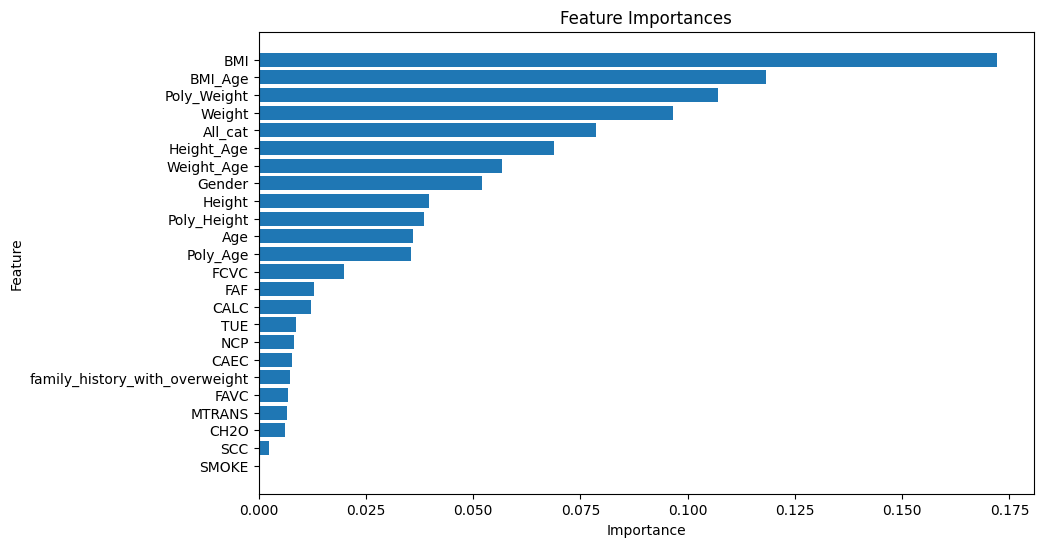

In [44]:
from sklearn.ensemble import RandomForestClassifier

# Initialize RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Fit classifier on training data
clf.fit(X_train, y_train)

# Extract feature importances
importances = clf.feature_importances_

# Combine feature names and importances into a DataFrame
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort feature importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display top feature subsets based on importance
print("Top Feature Subsets based on Importance:")
print(feature_importance_df.head(10))

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

## Generate predictions and submission

In [45]:
prediction_voting = voting_classifier.predict(test)

label_preds = label_encoder.inverse_transform(prediction_voting)

submission_df = pd.DataFrame({'id':ids, 'NObeyesdad': label_preds})

submission_df.to_csv('submission.csv', index=False)

[LightGBM] [Warning] feature_fraction is set=0.47602227848522155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47602227848522155
[LightGBM] [Warning] lambda_l2 is set=1.0389659121829367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0389659121829367
[LightGBM] [Warning] lambda_l1 is set=0.002077480169476262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002077480169476262
[LightGBM] [Warning] bagging_fraction is set=0.9290735275447844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9290735275447844
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
